# COMPUTATIONAL EFFICIENCY RESULTS

In [1]:

from data import UKDALEData
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from modelGen import modelGen
from address import get_model_path
%matplotlib inline



2023-12-09 13:49:17.760754: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataGen = UKDALEData(path="./data/")
trainMain,trainTargets, trainStates = dataGen.get_train_sequences(houses = 1,
                                                                  start = "2015-01-01",
                                                                  end="2016-01-01")
testMain,testTargets, testStates = dataGen.get_test_sequences(houses = 1,
                                                              start = "2016-01-01",
                                                              end="2016-02-01",
                                                              norm=False)


data= {"X_train":trainMain,
        "Y_train":trainTargets,
        "Y_states":trainStates,
        "Z_train":trainStates,
        "X_test":testMain,
        "Y_test":testTargets,
        "Z_test":testStates,
        "app_data":dataGen.get_app_data(),
        "main_data": dataGen.get_main_mean_std()
        } 

Loading the models

In [4]:

MODELSID = ["biLSTM","FCNdAE","multiFCNdAE","multiUNET"]
SEQ_LEN = [100,500,1440]
APP_LABELS = list(data["app_data"].keys())
MODELS = []
WEIGHTS = []
TIMES   = []
n = 10 # Number of inferences to compute the averaged inference time
%%capture

for seq in SEQ_LEN:
    w = []
    t = []
    for modelID in MODELSID:
        MODELS.append(modelGen(modelID=modelID,data=data, params = {"sequence_length":seq}))
        # weights
        w.append(MODELS[-1].get_num_weights())
        # inference times
        X_random = np.random.rand(10*60*5) #1 day of data
        t.append(MODELS[-1].get_inference_time(X_random,n))


    WEIGHTS.append(w)
    TIMES.append(t)

#for ii,modelID in enumerate(MODELSID):
#    print(f"nº trainable weights {modelID}: {WEIGHTS[ii]}")



2023-12-09 13:49:51.248534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 13:49:51.494484: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22311 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-12-09 13:49:54.547432: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-12-09 13:49:55.355565: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [5]:
WEIGHTS = np.array(WEIGHTS)
TIMES   = np.array(TIMES)
MODELSLABELS = ["biLSTM","FCNdAE","multiFCNdAE","UNET"]
df_weights = pd.DataFrame(WEIGHTS.T,columns=SEQ_LEN,index =MODELSLABELS)/1e6
df_weights = df_weights.loc[["multiFCNdAE","FCNdAE","UNET","biLSTM"]]

df_times   = pd.DataFrame(TIMES.T,columns=SEQ_LEN,index =MODELSLABELS)
df_times   = df_times.loc[["FCNdAE","UNET","multiFCNdAE","biLSTM"]]
df_times   = df_times # miliseconds

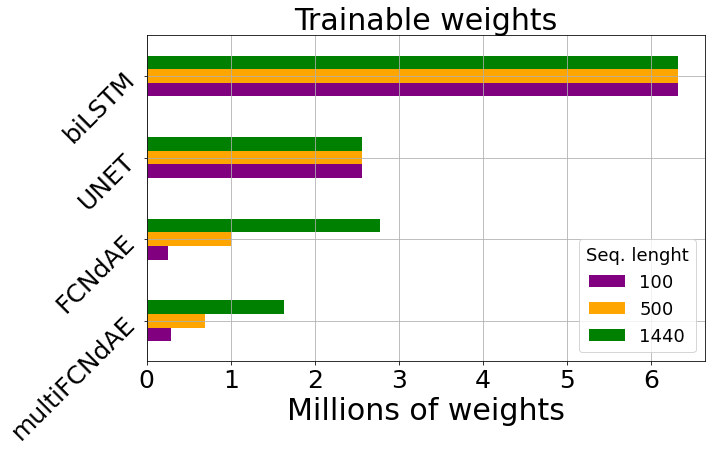

In [6]:
# Fig weights
colors = ['purple', 'orange','green']
ax = df_weights.plot.barh(grid=True,
                       color=colors,
                       figsize=(10,6))
plt.title("Trainable weights",fontdict={'fontsize':30})
plt.xlabel("Millions of weights",fontdict={'fontsize':30})
ax.tick_params("x",labelsize=25)
ax.tick_params("y",labelrotation=45,labelsize=25)
ax.legend(title="Seq. lenght",fontsize=18,title_fontsize=18)

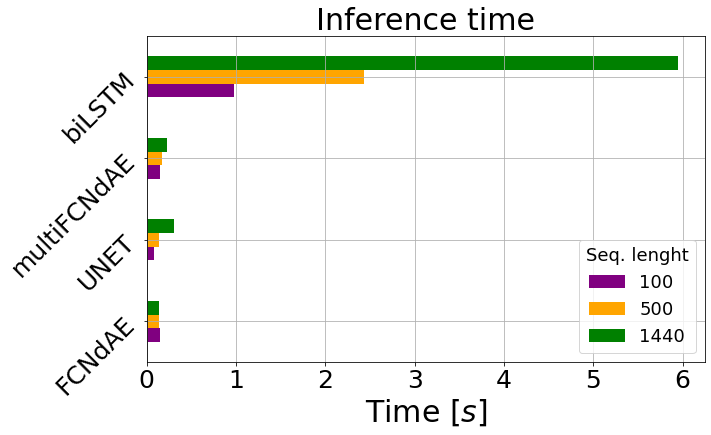

In [7]:
# Fig times
#df_times *=1000
colors = ['purple', 'orange','green']
ax = df_times.plot.barh(grid=True,
                       color=colors,
                       figsize=(10,6))
plt.title("Inference time",fontdict={'fontsize':30})
plt.xlabel(r"Time [$s$]",fontdict={'fontsize':30})
ax.tick_params("x",labelsize=25)
ax.tick_params("y",labelrotation=45,labelsize=25)
ax.legend(title="Seq. lenght",fontsize=18,title_fontsize=18)